
## Neural translation model


We created a neural network that translates from English to German.

Importing all the neccessary modules

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

import numpy as np

For the project, we used a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 260434 pairs of sentences in English and German. 

Our goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file.

Store the unzipped folder in Drive for use in this Colab notebook.
We will only be using 50000 pairs to reduce time for training.

In [2]:
# Connect to Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from Drive folder

NUM_EXAMPLES = 50000
data_examples = []
with open('/content/gdrive/My Drive/Colab Notebooks/Coursera TF2 IMPERIAL COLLEGE LONDON/C2. Customising your models with TensorFlow 2/WEEK 5/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [4]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture.

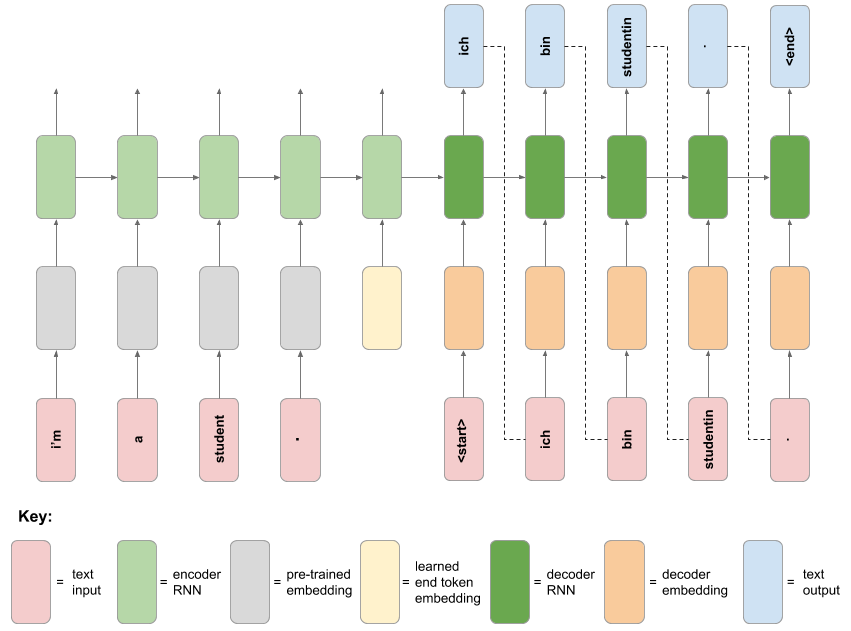

In [5]:
!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing


In [6]:
# Create separate lists of English and German sentences, and preprocess them using the preprocess_sentence function.

eng_sentences = []
german_sentences = []

# Using re.split to split the data in different parts and passing tab as pattern and data_examples as string .
# 1st part of split - English , 2nd part of split - German

for i in range(len(data_examples)):
    eng_sentences.append(preprocess_sentence(re.split('\t',data_examples[i])[0]))

    # Adding a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
    german_sentences.append('<start> ' + preprocess_sentence(re.split('\t',data_examples[i])[1]) + ' <end>')

In [7]:
# Using the Tokenizer class from the tf.keras.preprocessing.text module to tokenize the German sentences, ensuring that no character filters are applied.

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(german_sentences)
german_sentences_seq = tokenizer.texts_to_sequences(german_sentences)

In [8]:
# Printing out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. 
# For the German sentence, printed out the text (with start and end tokens) as well as the tokenized sequence.

num_sample = 5
rand_ind = np.random.choice(len(eng_sentences),5)

print('German Sentences :')
for i in rand_ind:
    print(german_sentences[i])
print()
print('Token sequences :')
for i in rand_ind:
    print(german_sentences_seq[i])
print()
print('English Sentences :')
for i in rand_ind:
    print(eng_sentences[i])

German Sentences :
<start> tom lief maria hinterher . <end>
<start> ich muss mich feinmachen . <end>
<start> tom ging spazieren . <end>
<start> wir werden unmoeglich aussehen . <end>
<start> wir haben besuch . <end>

Token sequences :
[1, 5, 735, 79, 1706, 3, 2]
[1, 4, 71, 24, 7769, 3, 2]
[1, 5, 131, 1229, 3, 2]
[1, 17, 80, 1349, 2263, 3, 2]
[1, 17, 34, 1641, 3, 2]

English Sentences :
tom chased after mary .
i have to dress up .
tom was walking .
we'll look ridiculous .
we have guests .


In [9]:
# Padding the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = max(map(len, german_sentences_seq))
german_sentences_seq_padded = pad_sequences(german_sentences_seq, maxlen=None, padding='post')
print(german_sentences_seq_padded.shape)

(50000, 19)


## 2. Prepare the data

#### Load the embedding layer
We used a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 



In [10]:
# Loading embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [11]:
# Testing the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In [12]:
# Creating a random training and validation set split of the data, reserving 20% of the data for validation

from sklearn.model_selection import train_test_split

eng_train,eng_valid,ger_train,ger_valid = train_test_split(eng_sentences,german_sentences_seq_padded,test_size = 0.20,shuffle=True)


* Creating a function to map over the datasets that splits each English sentence at spaces. 
* Creating a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. 
* Creating a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. 
* Creating a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. 

Applying above functions to both Dataset objects.
* Batch both training and validation Datasets with a batch size of 16.


In [13]:
# Setting the padding value for english sequences
padding_value = 0

# Defining a function that create and preprocess a Dataset
def get_preprocessed_dataset(x, y):
    # x refers to english sententences, y to german sequences
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(lambda x, y: (tf.strings.split(x, sep=' '), y))
    dataset = dataset.map(lambda x, y: (embedding_layer(x), y))
    dataset = dataset.filter(lambda x, y: tf.less(tf.shape(x)[0], tf.constant([13]))[0])
    dataset = dataset.map(lambda x, y: (tf.pad(x, paddings=[[13 - tf.shape(x)[0],0], [0, 0]], constant_values=padding_value), y))
    dataset = dataset.batch(16)
    return dataset

# Creating Dataset objects for training and validation
training_dataset = get_preprocessed_dataset(eng_train,ger_train)
validation_dataset = get_preprocessed_dataset(eng_valid,ger_valid)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
# Printing the element_spec property for the training and validation Datasets.

print(training_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.int32, name=None))


In [15]:
# Using the Dataset .take(1) method, printing the shape of the English and German data example from the training Dataset.

for english,german in training_dataset.take(1):
    print(english)
    print(german)

tf.Tensor(
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.0995407  -0.16360785  0.10037685 ... -0.15880379 -0.07032654
    0.13339032]
  [ 0.06729743  0.05527139 -0.18988505 ... -0.1769984   0.12503274
    0.02644952]
  [ 0.012986    0.08981702  0.16017003 ...  0.06796802  0.13528903
   -0.022035  ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.29264432 -0.06904604  0.0754334  ...  0.03079693 -0.02585435
    0.0311847 ]
  [ 0.00165811  0.04990025 -0.19440967 ... -0.01730713  0.03514429
    0.00545536]
  [ 0.012986    0.08981702  0.16017003 ...  0.06796802  0.13528903
   -0.022035  ]]

 [[ 0.          0.       

In [16]:
# Using the Dataset .take(1) method, print the English and German data example Tensor from the validation Dataset.

for english,german in validation_dataset.take(1):
    print(english)
    print(german)

tf.Tensor(
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.12862639  0.10774891  0.09832203 ... -0.09125718  0.00671368
    0.06453636]
  [ 0.16993822  0.04019142 -0.00206215 ... -0.07875071 -0.03067542
    0.11428136]
  [ 0.012986    0.08981702  0.16017003 ...  0.06796802  0.13528903
   -0.022035  ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.12846488  0.07159402  0.09918732 ... -0.07272145  0.03883429
    0.04847484]
  [ 0.04667116  0.05338951  0.07592631 ...  0.02667738  0.02897569
   -0.09239686]
  [ 0.012986    0.08981702  0.16017003 ...  0.06796802  0.13528903
   -0.022035  ]]

 [[ 0.          0.       

## 3. Create the custom layer
Creating a custom layer to add the learned end token embedding to the encoder model

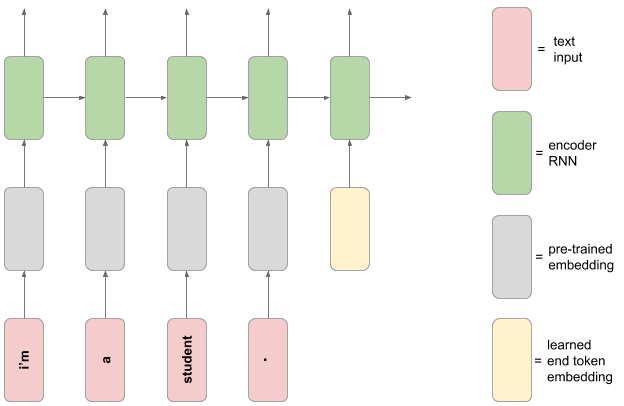

In [17]:
!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

In [18]:
from tensorflow.keras.layers import Layer,Input,Masking,LSTM,Embedding,Dense
from tensorflow.keras import Model

In [19]:
# Using layer subclassing, creating a custom layer that takes a batch of English data examples from one of the Datasets, 
# and adds a learned embedded ‘end’ token to the end of each sequence.

class MyLayer(Layer):
  
    def _init_(self, embedding_dim=128, **kwargs):
        super(MyLayer,self)._init_(**kwargs)
        self.embedding_dim = embedding_dim

    def build(self,input_shape):
        self.end_token_emb = self.add_weight(shape=(input_shape[-1],),
                                             initializer='random_uniform',
                                             trainable= True)
        
    def call(self, inputs):
        end_token = tf.tile(tf.reshape(self.end_token_emb, shape=(1, 1, self.end_token_emb.shape[0])), [tf.shape(inputs)[0],1,1])
        return tf.keras.layers.concatenate([inputs, end_token], axis=1)


In [20]:
# Using the Dataset .take(1) method, extracting a batch of English data examples from the training Dataset and printing the shape.
# Then testing the custom layer by calling the layer on the English data batch Tensor and printing the resulting Tensor shape 

endlayer = MyLayer()
for english,german in training_dataset.take(1):
    temp_layer = endlayer(english)
    print("English batch size before endlayer layer:")
    print(english.shape)

print("English batch size after endlayer layer:")
print(temp_layer.shape)

English batch size before endlayer layer:
(16, 13, 128)
English batch size after endlayer layer:
(16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. Building the RNN encoder model.
* Using the functional API
    * The model takes a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder is the custom layer created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value used when we padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.

In [21]:
def encoder(input_shape):
    inputs = Input(shape=input_shape)
    h = MyLayer()(inputs)
    h = Masking(mask_value=padding_value)(h)
    lstm = LSTM(512,return_sequences = True,return_state=True)(h)
    outputs = lstm[1:]
    encoder_model = Model(inputs=inputs, outputs=outputs)

    return encoder_model

In [22]:
# Using the Dataset `.take(1)` method, extracting a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor.
# Printing the shape of the resulting Tensor outputs.

english_batch, german_batch = next(iter(training_dataset.take(1)))
encoder_model = encoder(english_batch[0].shape)
hidden_state, cell_state = encoder_model(english_batch)

print(f'Shape of the batch of the encoded English sentences:\nhidden_state tensor: {hidden_state.shape}\ncell_state tensor: {cell_state.shape}\n')

# Printing the model summary for the encoder network.
encoder_model.summary()

Shape of the batch of the encoded English sentences:
hidden_state tensor: (16, 512)
cell_state tensor: (16, 512)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 128)]         0         
                                                                 
 my_layer_1 (MyLayer)        (None, 14, 128)           128       
                                                                 
 masking (Masking)           (None, 14, 128)           0         
                                                                 
 lstm (LSTM)                 [(None, 14, 512),         1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
___

## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

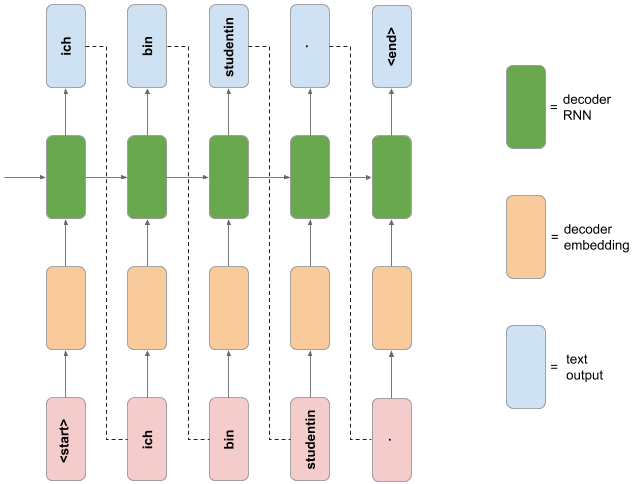

In [23]:
!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

building the RNN decoder model.
* Using Model subclassing
    * The initializer has the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.

    * The call method includes the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments is `None`.
    * The call method passes the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should beare used for the initial state of the LSTM layer. 
    * The call method passes the LSTM output sequence through the Dense layer, and returns the resulting Tensor, along with the hidden and cell states of the LSTM layer.


In [24]:
unique_tokens = len(tokenizer.word_index) + 1

In [25]:
class decoder(Model):
    def __init__(self,**kwargs):
        super(decoder, self).__init__(**kwargs)
        self.embedding_layer = Embedding(unique_tokens, 128, mask_zero=True)
        self.lstm_layer = LSTM(512, return_sequences=True, return_state=True)
        self.dense = Dense(unique_tokens)
  
    def call(self, inputs, hidden_state=None, cell_state=None):
        if hidden_state is not None and cell_state is not None:
            initial_state = [hidden_state, cell_state]
        else:
            initial_state = None
        embedding_output = self.embedding_layer(inputs)
        lstm_out, hidden, cell_state = self.lstm_layer(inputs=embedding_output,initial_state=initial_state)
        dense_out = self.dense(lstm_out)
        return dense_out, hidden, cell_state

decoder_model = decoder()

In [26]:
# Using the Dataset `.take(1)` method, extracting a batch of English and German data examples from the training Dataset. 
# Testing the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states,and 
# Then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.

english_batch, german_batch = next(iter(training_dataset.take(1)))
hidden_state, cell_state = encoder_model(english_batch)
decoded_batch, hidden, cell_state = decoder_model(german_batch,hidden_state=hidden_state, cell_state=cell_state)
print(f'Shape of the decoded batch: {decoded_batch.shape}')
print(f'Shape of the hiddent_state: {hidden.shape}')
print(f'Shape of the cell_state: {cell_state.shape}\n')

# Printing the model summary for the decoder network.
decoder_model.summary()

Shape of the decoded batch: (16, 19, 10459)
Shape of the hiddent_state: (16, 512)
Shape of the cell_state: (16, 512)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1338752   
                                                                 
 lstm_1 (LSTM)               multiple                  1312768   
                                                                 
 dense (Dense)               multiple                  5365467   
                                                                 
Total params: 8,016,987
Trainable params: 8,016,987
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
Writing a custom training loop to train custom neural translation model.
* Defining a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Defining a function that computes the forward and backward pass of the translation model. This function takes an English input, German input and German output as arguments, and does the following:
    * Passes the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss is computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorates the function with `@tf.function`
* Defining and running a custom training loop for a number of epochs:
    * Iterating through the training dataset, and creating decoder inputs and outputs from the German sequences.
    * Updating the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, computing the validation loss on a number of batches from the validation and saving the epoch training and validation losses.
* Plotting the learning curves for loss vs epoch for both training and validation sets.



In [27]:
# Create the German input and outputs for the decoder model.
def create(german_data):
    german_input = german_data[:,:-1]
    german_output = german_data[:,1:]
    return german_input, german_output

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

In [29]:
@tf.function(reduce_retracing=True)
def grad_fn(loss, encoder, decoder, english_input, german_input, german_output):
    with tf.GradientTape() as tape:
        hidden_state, cell_state = encoder_model(english_input)
        decoded_german, _, _ = decoder_model(german_input, hidden_state, cell_state)
        loss_value = loss(y_true=german_output, y_pred=decoded_german)
        encoder_gradient, decoder_gradient = tape.gradient(loss_value, (encoder_model.trainable_variables, decoder_model.trainable_variables))
    return loss_value, encoder_gradient, decoder_gradient


In [30]:
num_epochs = 10
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()

    #training loop 
    for english, german in training_dataset:
        # create the german input and output 
        german_in, german_out = create(german)
        #optimize the model
        loss_value, encoder_gradient, decoder_gradient = grad_fn(loss_object, encoder_model,decoder_model, english, german_in, german_out)
        optimizer.apply_gradients(zip(encoder_gradient + decoder_gradient, encoder_model.trainable_variables + decoder_model.trainable_variables))
        train_loss(loss_value)

    #validation loop
    for english, german in validation_dataset:
        # create the german input and output 
        german_in, german_out = create(german)
        # put it through the model
        hidden, cell_state = encoder_model(english)
        german_from_model,_,_= decoder_model(german_in, hidden, cell_state)
        loss_val = loss_object(y_true=german_out,y_pred=german_from_model)
        val_loss(loss_val)

    epoch_train_loss.append(train_loss.result())
    epoch_val_loss.append(val_loss.result())
    print(f"Epoch {epoch}")
    print(f"Training loss :  {epoch_train_loss[epoch]}")
    print(f"Validation loss :  {epoch_val_loss[epoch]}")
    print()
    

Epoch 0
Training loss :  3.05887770652771
Validation loss :  2.3896477222442627

Epoch 1
Training loss :  1.990935206413269
Validation loss :  1.940413236618042

Epoch 2
Training loss :  1.4530943632125854
Validation loss :  1.7518142461776733

Epoch 3
Training loss :  1.0710651874542236
Validation loss :  1.6735029220581055

Epoch 4
Training loss :  0.8004100322723389
Validation loss :  1.6435093879699707

Epoch 5
Training loss :  0.6097993850708008
Validation loss :  1.6435892581939697

Epoch 6
Training loss :  0.4790738821029663
Validation loss :  1.6675419807434082

Epoch 7
Training loss :  0.3820486068725586
Validation loss :  1.6913682222366333

Epoch 8
Training loss :  0.31376948952674866
Validation loss :  1.712707281112671

Epoch 9
Training loss :  0.263580322265625
Validation loss :  1.7442939281463623



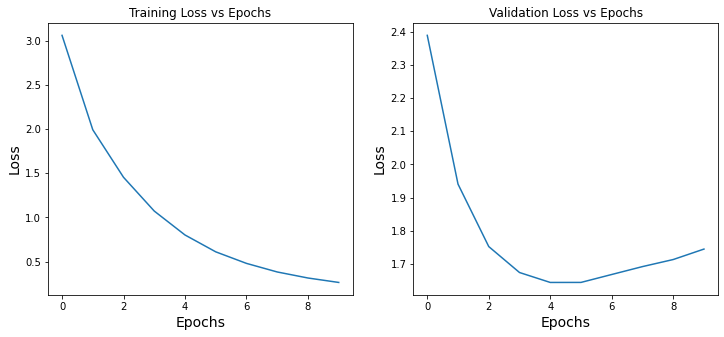

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the learning curves for loss vs epoch for both training and validation sets.
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Training Loss vs Epochs')
axes[0].plot(epoch_train_loss)

axes[1].set_title('Validation Loss vs Epochs')
axes[1].set_ylabel("Loss", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(epoch_val_loss)
plt.show()

## 7. Use the model to translate

* Preprocessing and embedding the English sentence according to the model requirements.
* Passing the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, using this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Creating a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminating the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Finally decoding the output token sequence into German text and print the English text and the model's German translation.

In [32]:
def preprocess_sentence_for_translation(sentence):
    x = preprocess_sentence(sentence)
    x = tf.constant(x)
    x = tf.strings.split(sentence, sep=' ')
    x = embedding_layer(x)
    x = tf.pad(x, paddings=[[13 - tf.shape(x)[0], 0], [0, 0]],constant_values=0)
    x = tf.expand_dims(x, axis=0)
    return x

def translate_sentence(sentence):
    x = preprocess_sentence_for_translation(sentence)

    # compute hidden and cell state using the encoding
    hidden_state, cell_state = encoder_model(x)

    # define the end and start token
    end_token = tokenizer.texts_to_sequences(['<end>'])
    input_token = tf.constant(tokenizer.texts_to_sequences(['<start>']))

    # initialize the output sequence
    output_sequence = []
    
    for i in range(maxlen):

        # compute the output scores and update hidden and cell state
        output_score, hidden_state, cell_state = decoder_model(input_token, hidden_state,cell_state)

        # find the word that maximizes the score
        input_token = tf.argmax(output_score, axis=2)
        idx = input_token.numpy()

        # check if the predicted word is the end token
        if idx == end_token:
            break

        # store the predicted token
        output_sequence.append(idx[0][0])

    # compute and print the output sentence
    output_sentence = tokenizer.sequences_to_texts([output_sequence])[0]
    return output_sentence

In [33]:
test_sentences = np.random.choice(eng_sentences, size=5, replace=False)
translated_sentences = []
for sentence in test_sentences:
    translated_sentences.append(translate_sentence(sentence))
for english_sentence, translated_sentence in zip(test_sentences,translated_sentences):
    print(f'{english_sentence:40s} {translated_sentence:40s}')

do you really not know ?                 verstehst du das nicht ?                
talk to me .                             rede mit mir !                          
i tried not to laugh .                   ich versuchte , nicht hinzusehen .      
i'll be fine .                           ich werde brav sein .                   
he'll never forgive me .                 er wird mir nie verzeihen .             
